<a href="https://colab.research.google.com/github/khoji-code/Data-Analysis/blob/main/Predicting_Customer's_Next_Action_in_an_Online_Shopping_Clickstream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Customer's Next Action in an Online Shopping Clickstream

## Interactive Plot - HTML file of the Code:
https://khoji-code.github.io/Data-Analysis/Click_Stream.html
***

### **Project Overview**

* **Goal:** To build a machine learning model that can accurately predict the main category of a product a customer will click on next, based on their clickstream data.
* **Dataset:** Utilizes the "e-shop clothing 2008" dataset, which contains clickstream data from an online clothing store.
* **Methodology:** The project involves an in-depth exploratory data analysis (EDA) with seasonal heatmaps and a hierarchical sunburst chart to visualize customer browsing patterns. An XGBoost multi-class classification model is trained to predict the next product category based on features like price, previous page views, and session information.
* **Key Results:** The model achieves a high accuracy of **98.08%**, demonstrating its effectiveness in predicting the next product category a user will visit. The feature importance analysis reveals that the most significant predictors are the prices of previously viewed items.

***

### **Purpose**

* **Enhance User Experience:** To create a model that can power a recommendation engine, suggesting relevant products to users in real-time and improving their browsing experience.
* **Increase Conversion Rates:** To provide e-commerce businesses with insights into customer navigation patterns, allowing them to optimize website layout and product placement to guide users towards a purchase.
* **Understand Customer Intent:** To identify the key drivers behind a customer's clickstream behavior, helping businesses to better understand user intent and tailor their marketing and sales strategies accordingly.

### Dataset:
https://archive.ics.uci.edu/dataset/553/clickstream+data+for+online+shopping

## INSTALL REQUIRED LIBRARIES

In [1]:
# Installing Libs
!pip install -q xgboost
!pip install -q plotly==5.24.1
!pip install -q -U kaleido==0.2.1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import warnings

# Explain: Ignore warnings for a cleaner output.
warnings.filterwarnings('ignore')

# ploty for interactive plots for show in github
import plotly.io as pio
# pio.renderers.default = 'notebook'
pio.renderers.default = 'jupyterlab+png'
# !jupyter nbconvert --to html /content/Click_Stream.ipynb # Convert to HTML Interactive Plot

print("Libraries imported successfully.")

Libraries imported successfully.


## LOAD AND PREPARE DATA

In [2]:
try:
    df = pd.read_csv('/content/drive/MyDrive/E-Shop Clothing/e-shop clothing 2008.csv', sep=';')
    print("Dataset loaded successfully. Shape:", df.shape)
except FileNotFoundError:
    print("Error: 'e-shop clothing 2008.csv' not found. Please upload the file.")
    exit()

Dataset loaded successfully. Shape: (165474, 14)


### Data Cleaning and Feature Engineering

In [3]:
# Clean up column names
df.columns = [col.strip().replace(' ', '_').replace('(', '').replace(')', '').lower() for col in df.columns]
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day']])
df.set_index('datetime', inplace=True)
df.drop(columns=['year', 'month', 'day'], inplace=True)

# Label-encoded version of page_1_main_category
le = LabelEncoder()
df['category_code'] = le.fit_transform(df['page_1_main_category'])
category_mapping = dict(zip(le.transform(le.classes_), le.classes_))

print("\nData cleaned and prepared.")
print(f"Main Categories Found: {list(category_mapping.values())}")


Data cleaned and prepared.
Main Categories Found: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


## EXPLORATORY DATA ANALYSIS (EDA)

### Seasonal Demand Heatmap

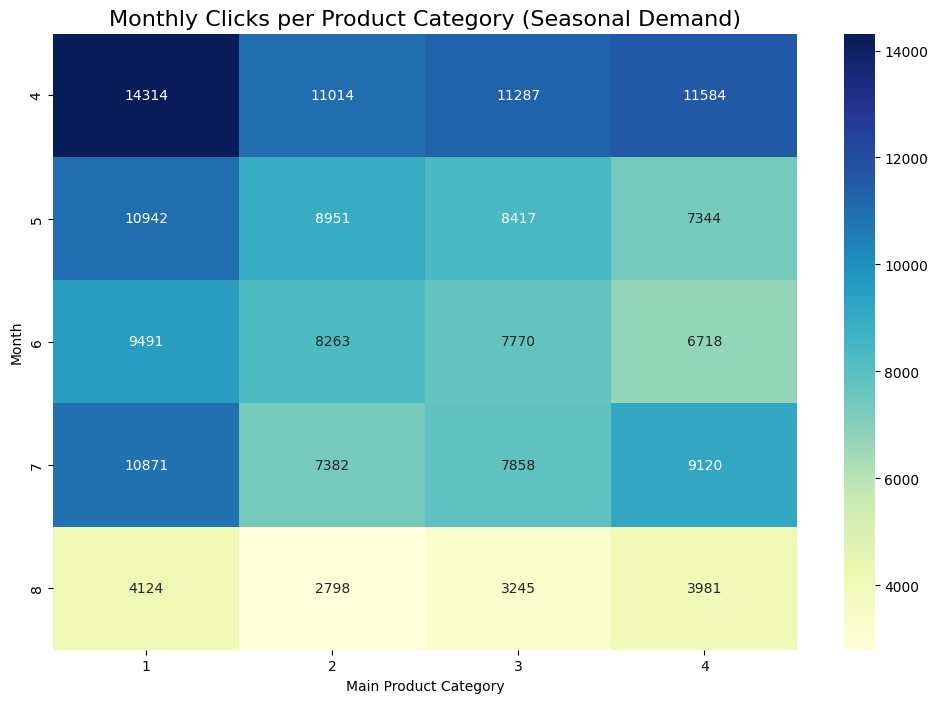

In [4]:
seasonal_data = df.groupby([df.index.month, 'page_1_main_category'])['session_id'].count().unstack()
seasonal_data.index.name = 'Month'
plt.figure(figsize=(12, 8))
sns.heatmap(seasonal_data, cmap='YlGnBu', annot=True, fmt=".0f")
plt.title('Monthly Clicks per Product Category (Seasonal Demand)', fontsize=16)
plt.ylabel('Month')
plt.xlabel('Main Product Category')
plt.show()

### Hierarchical Sunburst Chart

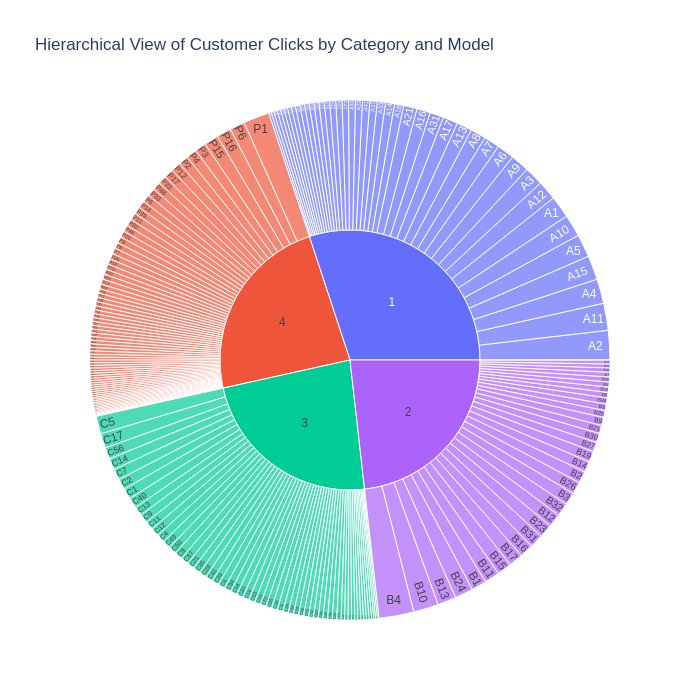

In [5]:
sunburst_data = df.groupby(['page_1_main_category', 'page_2_clothing_model']).size().reset_index(name='clicks')
fig = px.sunburst(
    sunburst_data,
    path=['page_1_main_category', 'page_2_clothing_model'],
    values='clicks',
    title='Hierarchical View of Customer Clicks by Category and Model',
    height=700
)
fig.show()

### Price Distribution by Category

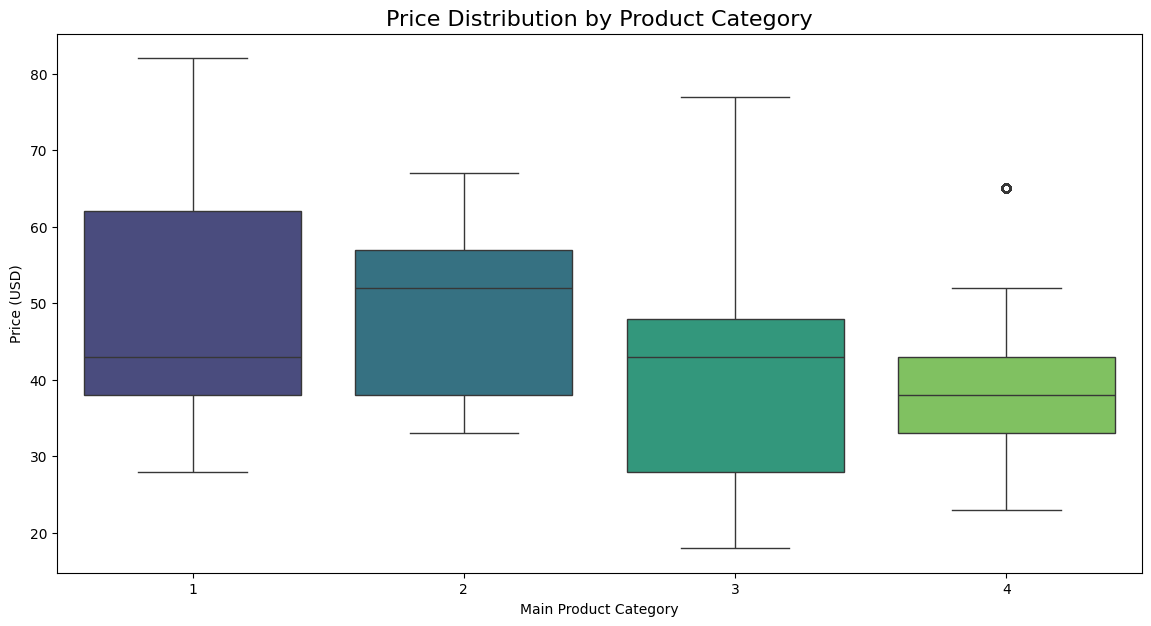

In [6]:
plt.figure(figsize=(14, 7))
sns.boxplot(x='page_1_main_category', y='price', data=df, palette='viridis')
plt.title('Price Distribution by Product Category', fontsize=16)
plt.xlabel('Main Product Category')
plt.ylabel('Price (USD)')
plt.show()

## MODELING WITH XGBOOST

In [7]:
# Feature and Target Separation
X = df.drop(['session_id', 'page_1_main_category', 'page_2_clothing_model', 'page', 'category_code'], axis=1)
y = df['category_code']

# Identify Column Types for Pipeline
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nIdentified {len(numerical_cols)} numerical and {len(categorical_cols)} categorical features.")



Identified 7 numerical and 0 categorical features.


### Create Preprocessing Pipeline

In [8]:
# ColumnTransformer to handle our mixed data types
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols)
    ],
    remainder='passthrough'
)

# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Create and Train the XGBoost Model Pipeline

In [9]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(category_mapping),
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    ))
])


model_pipeline.fit(X_train, y_train)
print("Model training complete.")


Model training complete.


## MODEL EVALUATION & INTERPRETATION

In [10]:

# Make Predictions and Evaluate
y_pred = model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
# Get the original category names
class_names = [str(c) for c in le.classes_]
print(classification_report(y_test, y_pred, target_names=class_names))

Model Accuracy: 0.9808

Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.99      0.98      9949
           2       0.98      0.97      0.97      7682
           3       0.99      0.98      0.98      7715
           4       0.98      0.99      0.98      7749

    accuracy                           0.98     33095
   macro avg       0.98      0.98      0.98     33095
weighted avg       0.98      0.98      0.98     33095



### Confusion Matrix

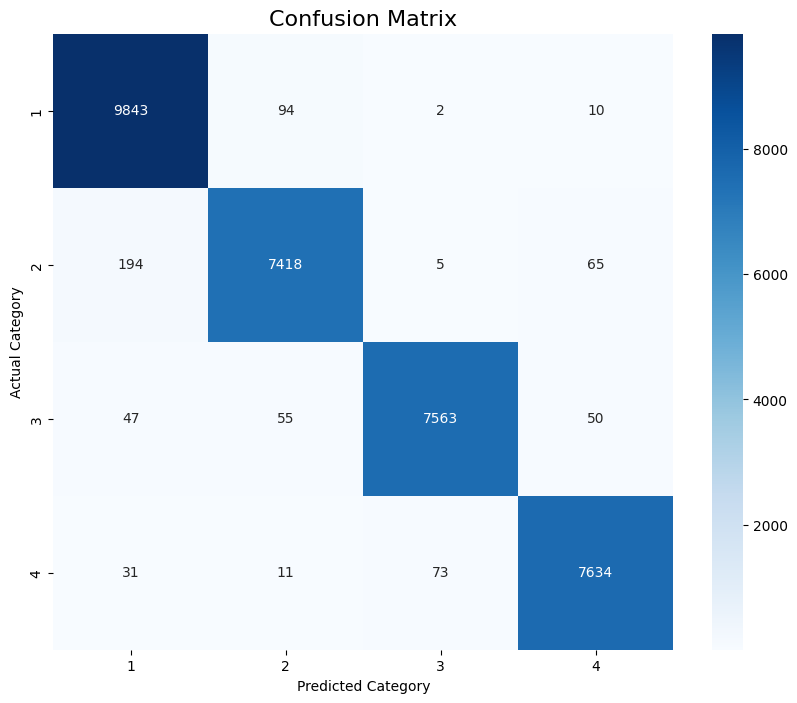

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.show()

### Feature Importance

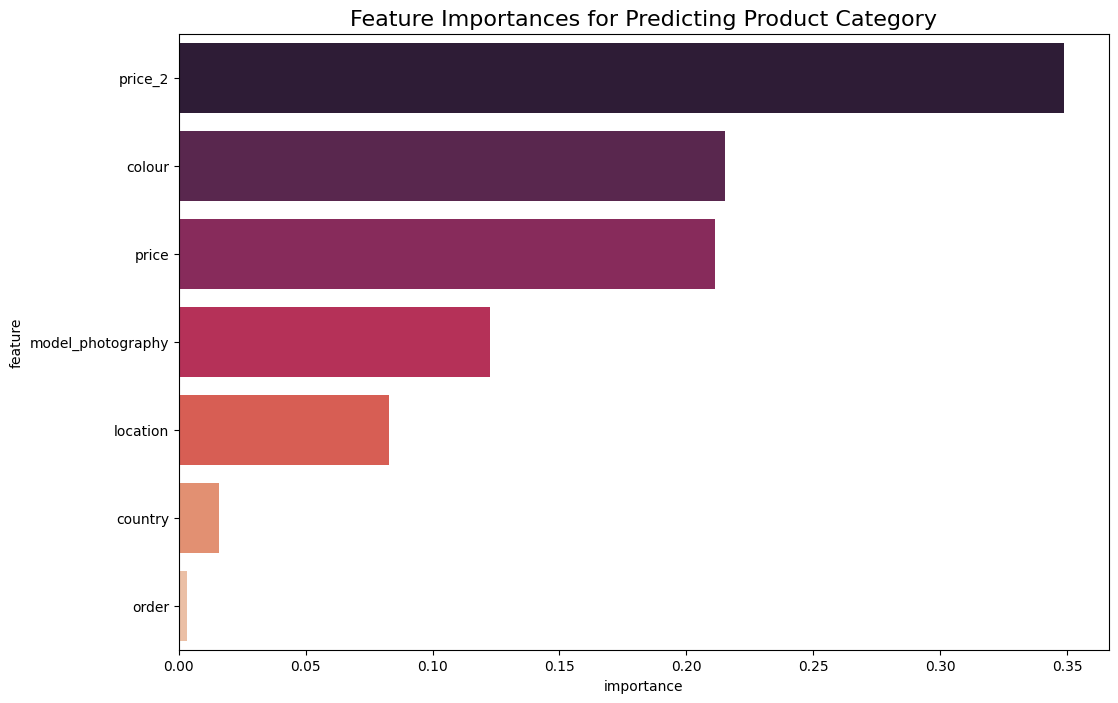

In [12]:
importances = model_pipeline.named_steps['classifier'].feature_importances_
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='rocket')
plt.title('Feature Importances for Predicting Product Category', fontsize=16)
plt.show()